In [2]:
import torch
import random
import numpy as np

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

In [3]:
import torchvision.datasets

MNIST_train = torchvision.datasets.MNIST('./', download=True, train=True)
MNIST_test = torchvision.datasets.MNIST('./', download=True, train=False)

In [4]:
sigma = 20

X_train = MNIST_train.train_data
y_train = MNIST_train.train_labels
X_test = torch.clamp(torch.add(MNIST_test.test_data, torch.normal(0, sigma, size=(10000, 28, 28)).int()), min=0, max=255)
y_test = MNIST_test.test_labels

c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:53: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:43: UserWarning: train_labels has been renamed targets
  warnings.warn("train_labels has been renamed targets")
c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:58: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
c:\program files\python37\lib\site-packages\torchvision\datasets\mnist.py:48: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


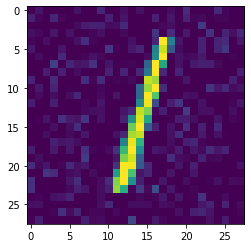

tensor(1)


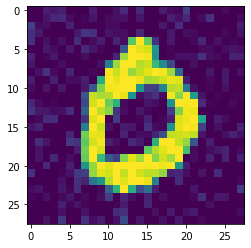

tensor(0)


In [5]:
import matplotlib.pyplot as plt
plt.imshow(X_test[2, :, :])
plt.show()
print(y_test[2])
plt.imshow(X_test[3, :, :])
plt.show()
print(y_test[3])

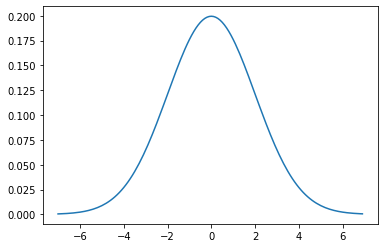

In [19]:
import math
sigma = 2
check = np.arange(-7., 7., 0.1)
plt.plot(check, 1 / (2 * math.sqrt(2 * math.pi)) * math.e ** (- check * check / (2 * sigma * sigma)))
plt.show()

In [112]:
X_train = X_train.unsqueeze(1).float()
X_test = X_test.unsqueeze(1).float()

In [113]:
X_train.shape

torch.Size([60000, 1, 28, 28])

In [114]:
class LeNet5(torch.nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        
        self.conv1 = torch.nn.Conv2d(
            in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.act1  = torch.nn.Tanh()
        self.pool1 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
       
        self.conv2 = torch.nn.Conv2d(
            in_channels=6, out_channels=16, kernel_size=5, padding=0)
        self.act2  = torch.nn.Tanh()
        self.pool2 = torch.nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.fc1   = torch.nn.Linear(5 * 5 * 16, 120)
        self.act3  = torch.nn.Tanh()
        
        self.fc2   = torch.nn.Linear(120, 84)
        self.act4  = torch.nn.Tanh()
        
        self.fc3   = torch.nn.Linear(84, 10)
    
    def forward(self, x):
        
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        
        x = x.view(x.size(0), x.size(1) * x.size(2) * x.size(3))

        x = self.fc1(x)
        x = self.act3(x)
        x = self.fc2(x)
        x = self.act4(x)
        x = self.fc3(x)
        
        return x
    
lenet5 = LeNet5()

In [115]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
lenet5 = lenet5.to(device)

In [116]:
loss = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lenet5.parameters(), lr=1.0e-3)

In [117]:
batch_size = 100

test_accuracy_history = []
test_loss_history = []

X_test = X_test.to(device)
y_test = y_test.to(device)

for epoch in range(10000):
    order = np.random.permutation(len(X_train))
    for start_index in range(0, len(X_train), batch_size):
        optimizer.zero_grad()
        
        batch_indexes = order[start_index:start_index+batch_size]
        
        X_batch = X_train[batch_indexes].to(device)
        y_batch = y_train[batch_indexes].to(device)
        
        preds = lenet5.forward(X_batch) 
        
        loss_value = loss(preds, y_batch)
        loss_value.backward()
        
        optimizer.step()
        
    test_preds = lenet5.forward(X_test)
    test_loss_history.append(loss(test_preds, y_test).data.cpu())
    
    accuracy = (test_preds.argmax(dim=1) == y_test).float().mean().data.cpu()
    test_accuracy_history.append(accuracy)
    
    print(accuracy)

tensor(0.9150)
tensor(0.9478)
tensor(0.9411)
tensor(0.9175)


KeyboardInterrupt: 

In [16]:
lenet5.forward(X_test)

tensor([[ 0.0328, -0.3213,  0.7643,  ...,  9.4868, -1.0379,  1.4897],
        [ 0.1164,  1.4963,  7.2772,  ..., -2.0880,  1.6666, -3.7978],
        [-1.3170,  8.4430, -1.1971,  ...,  0.2831,  0.9594, -1.5008],
        ...,
        [-2.2658,  0.4854, -2.1476,  ...,  1.6434,  0.1333,  2.3443],
        [-0.2101, -1.9369, -3.1990,  ..., -4.6364,  2.8629, -0.5178],
        [ 0.9896, -0.8345,  0.1522,  ..., -4.5833, -1.1458, -3.0171]],
       device='cuda:0', grad_fn=<AddmmBackward>)

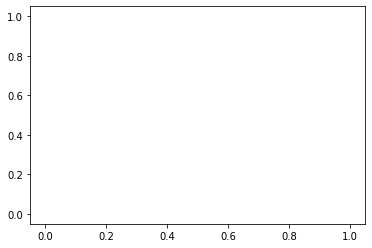

In [17]:
# plt.plot(test_accuracy_history);
plt.plot(test_loss_history);